In [1]:
# Import des 

# Import des packages 
import pandas as pd
import numpy as np
import pathlib
import os
import gc
#from scipy import sparse

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

# Keras et tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
print(tf.__version__)

# On vérifie que la gpu fonctionne

tf.config.list_physical_devices('GPU')

2.8.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# En repartant du dataset tabulaire
C'est possible mais pas ideal car il est long à créer
Cela pourrait tout de même être intéressant pour pouvoir utiliser l info URL

In [ ]:
# Charger le dataset tabulaire préprocessé ne fonctionne pas pour utilisation de tensorflow

# file = r"C:\Users\Inrae\Documents\Projet_Data_Science\radio_tab.csv"

# # Dataset complet mais reduit en 100*100

# df = pd.read_csv(file)
# # On cree un jeu de données réduit en respectant les proportions initiales 

# df.rename(columns = {'Unnamed: 0':'FILENAME'}, inplace = True)

# df = df.set_index("FILENAME")

# #df = df.rename(columns = {'Unnamed : 0' : 'FILENAME'})
# df.head()


# On recode la variable source

#cat_url = pd.get_dummies(df["URL"], prefix="url")

#df = pd.concat([cat_url, df], axis=1)

#X = df.drop(["URL","SIZE","FORMAT","TYPE","num"], axis=1)

#X.head()


# En repartant du notebook de MME pour l'import des données
## Preprocessing et export des données masquées

In [21]:

# # On recrée un répertoire de données préprocessées, redimensionnées en 224*224 avec filtre gaussien et masquage

# path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
# data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")
# output_path = os.path.join(path_to_data,"processed")
# folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# make_tiny=False
# tiny_size=1000
# final_size=(224,224)

# for img_type in  folder_to_process:
#     print(f"Processing folder: {img_type}")

#     img_folder_path = os.path.join(data_folder_path,img_type,"images")
#     mask_folder_path = os.path.join(data_folder_path,img_type,"masks")

#     output_folder_path = os.path.join(output_path, img_type)
#     #output_folder_path.mkdir(parents=True, exist_ok=True)

#     nb_image_done = 0
#     for image_name, mask_name in zip(os.listdir(img_folder_path),
#                                      os.listdir(mask_folder_path)):

#         image_path = os.path.join(img_folder_path, image_name)
#         mask_path = os.path.join(mask_folder_path, mask_name)

#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         # resized to mask size
#         image = cv2.resize(image, dsize = (256, 256)) # fixed size to mask size

#         # masking
#         res =  cv2.bitwise_and(image, image, mask=mask)
#         res = cv2.GaussianBlur(res, ksize = (3,3), sigmaX=0.2)
#         res = cv2.resize(res, dsize = final_size)

#         # Write masked image
#         output_image_name = image_name + '_masked.png'
#         output_file =  os.path.join(output_folder_path, output_image_name)
#         cv2.imwrite(output_file, res)

#         nb_image_done += 1
#         if make_tiny and nb_image_done >= tiny_size:
#             break

#     print(f"Processing folder: {img_type} done.")


## On importe les images préprocessées et masquées

In [3]:

path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")
output_path = os.path.join(path_to_data,"processed")
final_size=(224,224)

# Import des données on sépare entre apprentissage et validation
batch_size=32
data_dir=output_path
size=final_size

# On laisse en couleur pour pouvoir utiliser les modeles preentrainés

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    #color_mode= "grayscale",
    seed=42,
    image_size=size,
    batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="validation",
    #color_mode= "grayscale",
    seed=42,
    image_size=size,
    batch_size=batch_size)



Found 21165 files belonging to 4 classes.
Using 10583 files for training.
Found 21165 files belonging to 4 classes.
Using 10582 files for validation.


In [6]:
# Création X_train, X_test, y_train, y_test

# For train data
all_images = []
all_labels = []

for images, labels in train_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_train = np.concatenate(all_images)
y_train = np.concatenate(all_labels)

# For test data
all_images = []
all_labels = []

for images, labels in val_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images)
y_test = np.concatenate(all_labels)

# normalization
X_train = X_train / 255
X_test = X_test / 255

# encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [7]:
# On cree un generateur d image

train_datagen = ImageDataGenerator(
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    #horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    #width_shift_range=0.1,
    #height_shift_range=0.1  
    ) 

test_datagen = ImageDataGenerator()

# Augmenter respectivement les jeu de données d'entrainement
train_dataset = train_datagen.flow(X_train,y_train,   batch_size = 64)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 64)



# Modèle de DL
## Test d un premier modèle from scratch

In [7]:
# Construction d un modèle classique

model = Sequential()

# Couche d'entrée pour les images 224x224 avec 3 canaux (RGB) 
model.add(Input(shape=(224, 224, 3))) 

# Première couche de convolution 
model.add(Conv2D(16, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2))) 

# Deuxième couche de convolution 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2))) 

# Troisième couche de convolution 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2)))

# Quatireme couche de convolution 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2)))


# Couche flatten pour transformer les cartes de caractéristiques en un vecteur 
model.add(Flatten()) 

# Ajouter des couches fully connected (denses) 

model.add(Dense(60, activation='relu')) 
model.add(Dense(4, activation='softmax')) 

#Compiler le modèle model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir le learning rate désiré 
learning_rate = 0.001 #

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

#Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks 

batch_size = 64
epochs = 10 
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            verbose=True)

NameError: name 'X_train' is not defined

## RESNET préentrainé sur image net
### En utilisant directement le modèle

In [4]:
# On importe un modele préentrainé : REsnet50
# https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes
#import h5py

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(weights='imagenet')

#base_model.summary()


len(base_model.layers)


177

#### Sans data augmentation
##### Avec un learning rate de 0.001


In [25]:
del history
del model
del base_model
del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 


# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =10,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/10
231/231 [==============================] - 112s 477ms/step - loss: 1.1128 - accuracy: 0.5608 - val_loss: 0.9769 - val_accuracy: 0.6153
Epoch 2/10
231/231 [==============================] - 114s 492ms/step - loss: 0.9177 - accuracy: 0.6367 - val_loss: 0.9001 - val_accuracy: 0.6444
Epoch 3/10
231/231 [==============================] - 110s 475ms/step - loss: 0.8541 - accuracy: 0.6633 - val_loss: 0.8593 - val_accuracy: 0.6595
Epoch 4/10
231/231 [==============================] - 128s 552ms/step - loss: 0.8149 - accuracy: 0.6760 - val_loss: 0.8214 - val_accuracy: 0.6729
Epoch 5/10
231/231 [==============================] - 121s 521ms/step - loss: 0.7878 - accuracy: 0.6899 - val_loss: 0.7999 - val_accuracy: 0.6811
Epoch 6/10
231/231 [==============================] - 125s 538ms/step - loss: 0.7665 - accuracy: 0.6952 - val_loss: 0.7872 - val_accuracy: 0.6901
Epoch 7/10
231/231 [===================

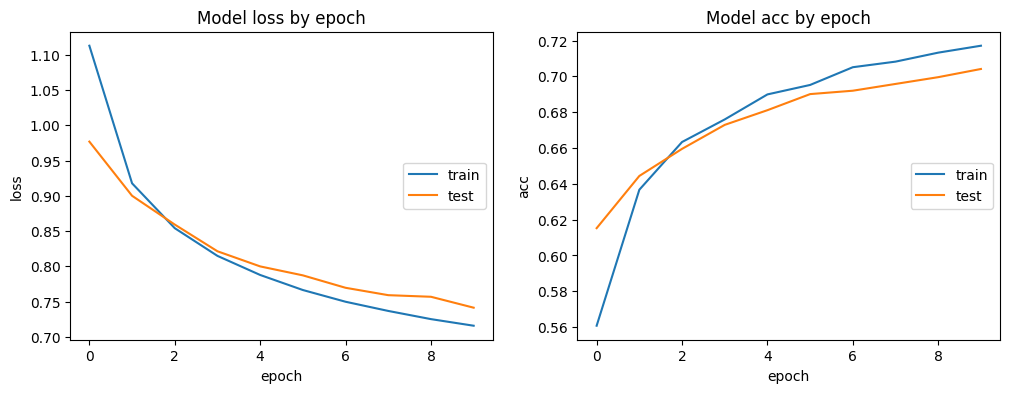

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.56      0.32      0.40      1084
   Lung_Opacity       0.70      0.66      0.68      1803
         Normal       0.75      0.89      0.81      3057
Viral_Pneumonia       0.57      0.51      0.54       403

       accuracy                           0.70      6347
      macro avg       0.64      0.60      0.61      6347
   weighted avg       0.69      0.70      0.69      6347



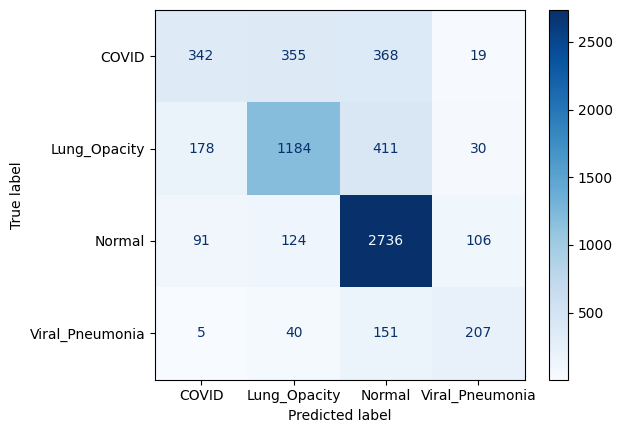

In [28]:
test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

##### Avec un learning rate de 0.0001

In [36]:
#del history
# del model
# del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

learning_rate = 0.0001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =5,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/5
231/231 [==============================] - 112s 476ms/step - loss: 1.3334 - accuracy: 0.5676 - val_loss: 1.2878 - val_accuracy: 0.5639
Epoch 2/5
231/231 [==============================] - 109s 473ms/step - loss: 1.2377 - accuracy: 0.5751 - val_loss: 1.1949 - val_accuracy: 0.5670
Epoch 3/5
231/231 [==============================] - 110s 477ms/step - loss: 1.1563 - accuracy: 0.5825 - val_loss: 1.1269 - val_accuracy: 0.5716
Epoch 4/5
231/231 [==============================] - 110s 475ms/step - loss: 1.0971 - accuracy: 0.5920 - val_loss: 1.0790 - val_accuracy: 0.5844
Epoch 5/5
231/231 [==============================] - 118s 509ms/step - loss: 1.0547 - accuracy: 0.6046 - val_loss: 1.0448 - val_accuracy: 0.5970


##### Avec un learning rate de 0.01

In [38]:
#del history
# del model
# del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

learning_rate = 0.01 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =10,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/10
231/231 [==============================] - 119s 505ms/step - loss: 0.8738 - accuracy: 0.6513 - val_loss: 0.7799 - val_accuracy: 0.6912
Epoch 2/10
231/231 [==============================] - 113s 487ms/step - loss: 0.7243 - accuracy: 0.7132 - val_loss: 0.7194 - val_accuracy: 0.7159
Epoch 3/10
231/231 [==============================] - 115s 497ms/step - loss: 0.6818 - accuracy: 0.7320 - val_loss: 0.7004 - val_accuracy: 0.7243
Epoch 4/10
231/231 [==============================] - 117s 504ms/step - loss: 0.6595 - accuracy: 0.7415 - val_loss: 0.7154 - val_accuracy: 0.7194
Epoch 5/10
231/231 [==============================] - 115s 496ms/step - loss: 0.6347 - accuracy: 0.7501 - val_loss: 0.6605 - val_accuracy: 0.7386
Epoch 6/10
231/231 [==============================] - 116s 502ms/step - loss: 0.6210 - accuracy: 0.7598 - val_loss: 0.6696 - val_accuracy: 0.7492
Epoch 7/10
231/231 [===================

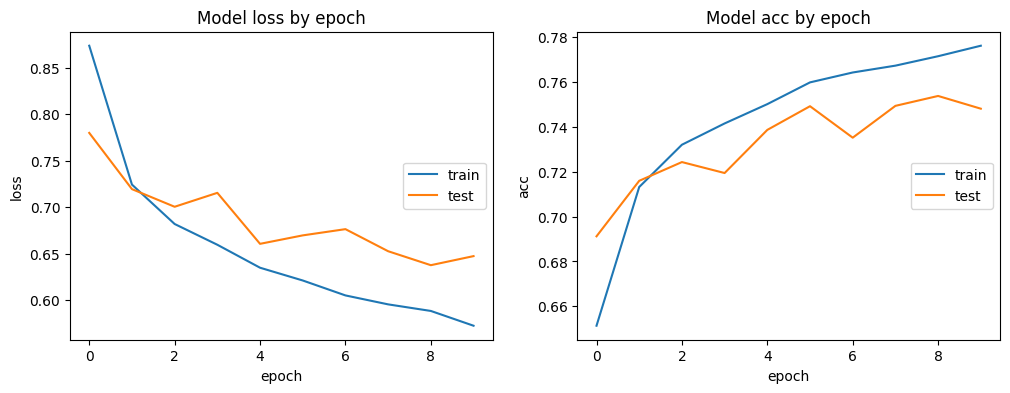

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.61      0.42      0.50      1084
   Lung_Opacity       0.76      0.69      0.72      1803
         Normal       0.79      0.90      0.84      3057
Viral_Pneumonia       0.63      0.78      0.69       403

       accuracy                           0.75      6347
      macro avg       0.70      0.69      0.69      6347
   weighted avg       0.74      0.75      0.74      6347



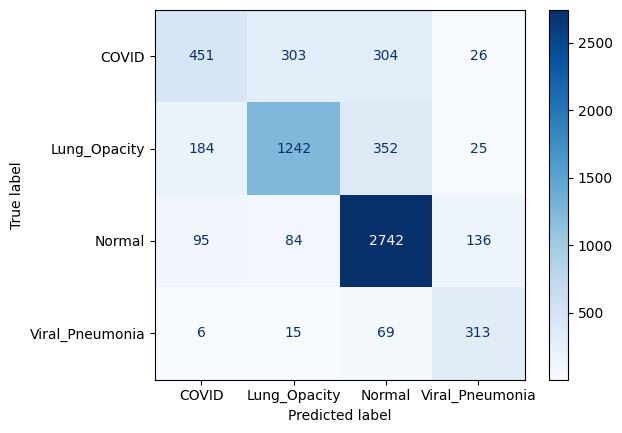

In [40]:
test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

##### ReduceLRonPlateau et early_stop

In [69]:
#del history
del model
del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

#learning_rate = 0.01 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.01) 

# On crée des callback pour diminuer le LR

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    min_lr=0.0001,
    min_delta =  0.05,
    verbose = 1
)


stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.01,
    verbose = 1 )

my_callbacks = [
    lr_callback,
    stop_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

#K.set_value(model.optimizer.lr, 1e-2)

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 130s 552ms/step - loss: 0.8711 - accuracy: 0.6542 - val_loss: 0.7752 - val_accuracy: 0.6862 - lr: 0.0100
Epoch 2/20
231/231 [==============================] - 111s 478ms/step - loss: 0.7228 - accuracy: 0.7169 - val_loss: 0.7569 - val_accuracy: 0.7117 - lr: 0.0100
Epoch 3/20
231/231 [==============================] - 111s 480ms/step - loss: 0.6815 - accuracy: 0.7314 - val_loss: 0.7087 - val_accuracy: 0.7167 - lr: 0.0100
Epoch 4/20
231/231 [==============================] - 111s 479ms/step - loss: 0.6555 - accuracy: 0.7423 - val_loss: 0.6886 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 5/20
231/231 [==============================] - 112s 483ms/step - loss: 0.6327 - accuracy: 0.7519 - val_loss: 0.6544 - val_accuracy: 0.7465 - lr: 0.0100
Epoch 6/20
231/231 [==============================] - 109s 473ms/step - loss: 0.6174 - accuracy: 0.7574 - val_loss: 0.65

##### LR scheduler et early stop

In [73]:
#del history
del model
del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

#learning_rate = 0.01 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

    


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.01) 

# On crée des callback pour diminuer le LR

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.01,
    verbose = 1 )

my_callbacks = [
    scheduler_callback,
    stop_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])


# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])


Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 114s 481ms/step - loss: 0.8683 - accuracy: 0.6524 - val_loss: 0.7701 - val_accuracy: 0.6898 - lr: 0.0100
Epoch 2/20
231/231 [==============================] - 109s 473ms/step - loss: 0.7248 - accuracy: 0.7122 - val_loss: 0.7216 - val_accuracy: 0.7191 - lr: 0.0100
Epoch 3/20
231/231 [==============================] - 110s 474ms/step - loss: 0.6778 - accuracy: 0.7364 - val_loss: 0.7025 - val_accuracy: 0.7200 - lr: 0.0100
Epoch 4/20
231/231 [==============================] - 110s 476ms/step - loss: 0.6519 - accuracy: 0.7451 - val_loss: 0.6901 - val_accuracy: 0.7350 - lr: 0.0100
Epoch 5/20
231/231 [==============================] - 109s 473ms/step - loss: 0.6366 - accuracy: 0.7530 - val_loss: 0.6556 - val_accuracy: 0.7416 - lr: 0.0100
Epoch 6/20
231/231 [==============================] - 109s 471ms/step - loss: 0.6163 - accuracy: 0.7601 - val_loss: 0.67

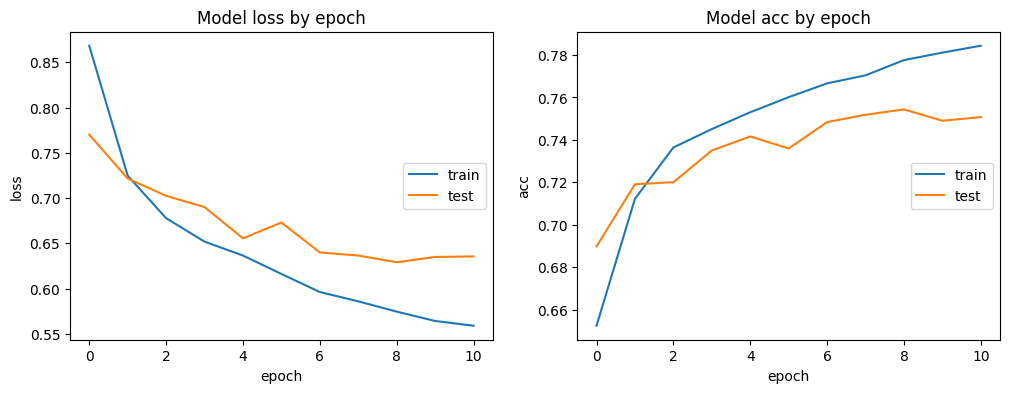

In [74]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.57      0.49      0.53      1084
   Lung_Opacity       0.71      0.72      0.72      1803
         Normal       0.83      0.87      0.85      3057
Viral_Pneumonia       0.72      0.65      0.68       403

       accuracy                           0.75      6347
      macro avg       0.71      0.68      0.69      6347
   weighted avg       0.74      0.75      0.75      6347



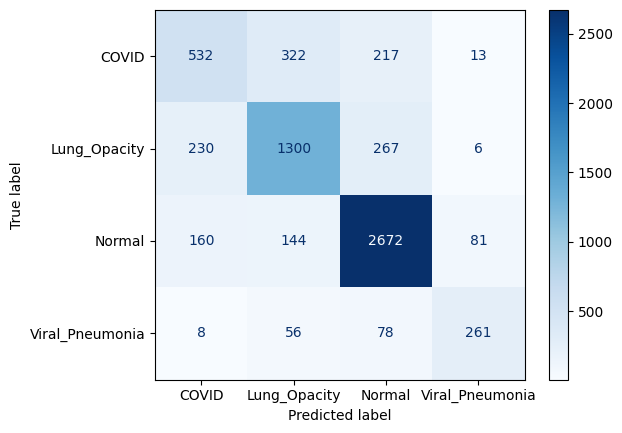

In [77]:
test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

#### Avec data augmentation, LR scheduler et early stop

In [79]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.01) 

# On crée des callback pour diminuer le LR

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.005,
    verbose = 1 )

my_callbacks = [
    scheduler_callback,
    stop_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])


# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])


Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 221s 946ms/step - loss: 0.8754 - accuracy: 0.6490 - val_loss: 0.8110 - val_accuracy: 0.6717 - lr: 0.0100
Epoch 2/20
231/231 [==============================] - 378s 2s/step - loss: 0.7318 - accuracy: 0.7108 - val_loss: 0.7661 - val_accuracy: 0.6895 - lr: 0.0100
Epoch 3/20
231/231 [==============================] - 1189s 5s/step - loss: 0.6890 - accuracy: 0.7231 - val_loss: 0.7498 - val_accuracy: 0.6977 - lr: 0.0100
Epoch 4/20
231/231 [==============================] - 241s 1s/step - loss: 0.6679 - accuracy: 0.7331 - val_loss: 0.7456 - val_accuracy: 0.7047 - lr: 0.0090
Epoch 5/20
231/231 [==============================] - 247s 1s/step - loss: 0.6521 - accuracy: 0.7394 - val_loss: 0.7221 - val_accuracy: 0.7192 - lr: 0.0082
Epoch 6/20
231/231 [==============================] - 227s 981ms/step - loss: 0.6417 - accuracy: 0.7466 - val_loss: 0.7169 - val_ac

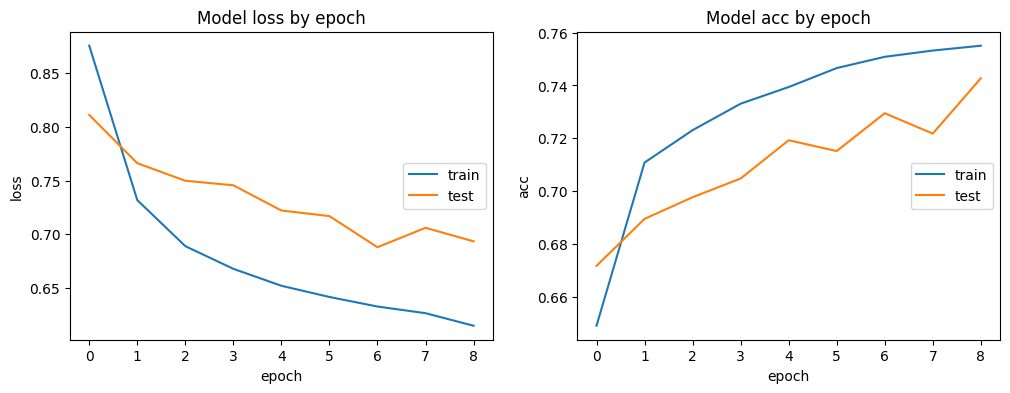

In [80]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.62      0.33      0.43      1084
   Lung_Opacity       0.72      0.71      0.72      1803
         Normal       0.78      0.91      0.84      3057
Viral_Pneumonia       0.69      0.71      0.70       403

       accuracy                           0.74      6347
      macro avg       0.70      0.67      0.67      6347
   weighted avg       0.73      0.74      0.73      6347



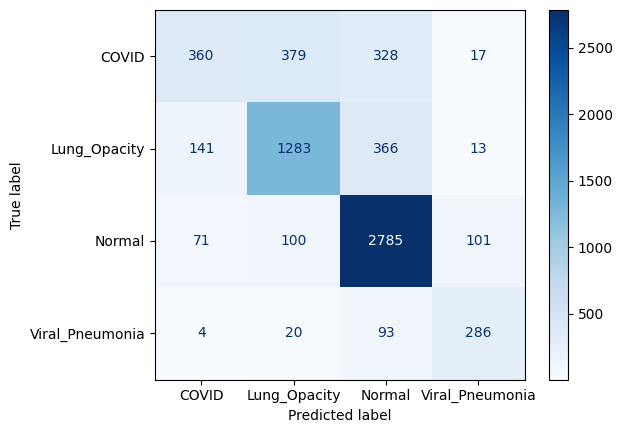

In [81]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

### Degel des paramètres des dernières couches
#### On dégèle les 7 dernieres couches

In [92]:
# del history
#del model
#del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()


# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)


# first:  freeze all convolutional InceptionV3 layers

for layer in model.layers[:170]:
   layer.trainable = False
for layer in model.layers[170:]:
   layer.trainable = True


#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.01) 

# On crée des callback pour diminuer le LR

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.005,
    verbose = 1 )

my_callbacks = [
    scheduler_callback,
    stop_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])


# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])


Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 253s 1s/step - loss: 0.8408 - accuracy: 0.6709 - val_loss: 0.7905 - val_accuracy: 0.6441 - lr: 0.0100
Epoch 2/20
231/231 [==============================] - 253s 1s/step - loss: 0.7834 - accuracy: 0.6884 - val_loss: 0.7481 - val_accuracy: 0.7024 - lr: 0.0100
Epoch 3/20
231/231 [==============================] - 250s 1s/step - loss: 0.7657 - accuracy: 0.7078 - val_loss: 0.7641 - val_accuracy: 0.6494 - lr: 0.0100
Epoch 4/20
231/231 [==============================] - 240s 1s/step - loss: 0.7294 - accuracy: 0.7084 - val_loss: 0.7402 - val_accuracy: 0.6871 - lr: 0.0090
Epoch 5/20
231/231 [==============================] - 241s 1s/step - loss: 0.7215 - accuracy: 0.7264 - val_loss: 0.7001 - val_accuracy: 0.7358 - lr: 0.0082
Epoch 6/20
231/231 [==============================] - 245s 1s/step - loss: 0.7072 - accuracy: 0.7482 - val_loss: 0.7175 - val_accuracy:

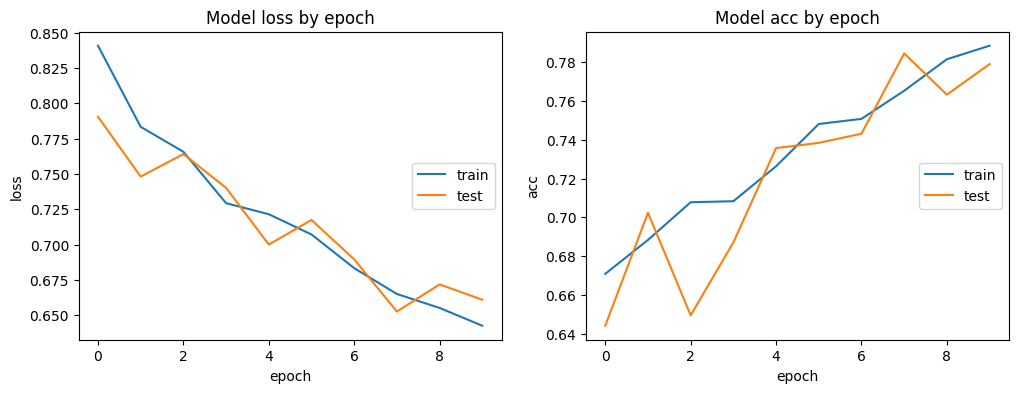

In [96]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.73      0.20      0.32      1084
   Lung_Opacity       0.67      0.86      0.75      1803
         Normal       0.86      0.92      0.89      3057
Viral_Pneumonia       0.82      0.88      0.84       403

       accuracy                           0.78      6347
      macro avg       0.77      0.72      0.70      6347
   weighted avg       0.78      0.78      0.75      6347



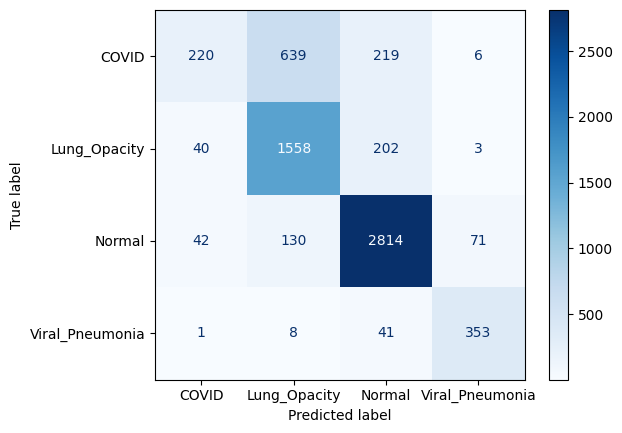

In [98]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

In [ ]:
## Sauvegarde du model



#### Degel des 15 dernieres couches

In [14]:
#del history
#del model
#del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()


# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)


# first:  freeze all convolutional InceptionV3 layers

for layer in model.layers[:160]:
   layer.trainable = False
for layer in model.layers[160:]:
   layer.trainable = True


#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.01) 

# On crée des callback pour diminuer le LR

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.005,
    verbose = 1 )

my_callbacks = [
    scheduler_callback,
    stop_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])


# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])


Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 180s 759ms/step - loss: 0.7856 - accuracy: 0.6990 - val_loss: 0.7147 - val_accuracy: 0.7389 - lr: 0.0100
Epoch 2/20
231/231 [==============================] - 192s 829ms/step - loss: 0.7036 - accuracy: 0.7352 - val_loss: 0.6643 - val_accuracy: 0.7356 - lr: 0.0100
Epoch 3/20
231/231 [==============================] - 179s 771ms/step - loss: 0.6899 - accuracy: 0.7412 - val_loss: 0.6779 - val_accuracy: 0.7481 - lr: 0.0100
Epoch 4/20
231/231 [==============================] - 180s 776ms/step - loss: 0.6749 - accuracy: 0.7460 - val_loss: 0.6581 - val_accuracy: 0.7602 - lr: 0.0100
Epoch 5/20
231/231 [==============================] - 172s 745ms/step - loss: 0.6344 - accuracy: 0.7598 - val_loss: 0.6532 - val_accuracy: 0.7749 - lr: 0.0100
Epoch 6/20
231/231 [==============================] - 168s 725ms/step - loss: 0.5971 - accuracy: 0.7837 - val_loss: 0.61

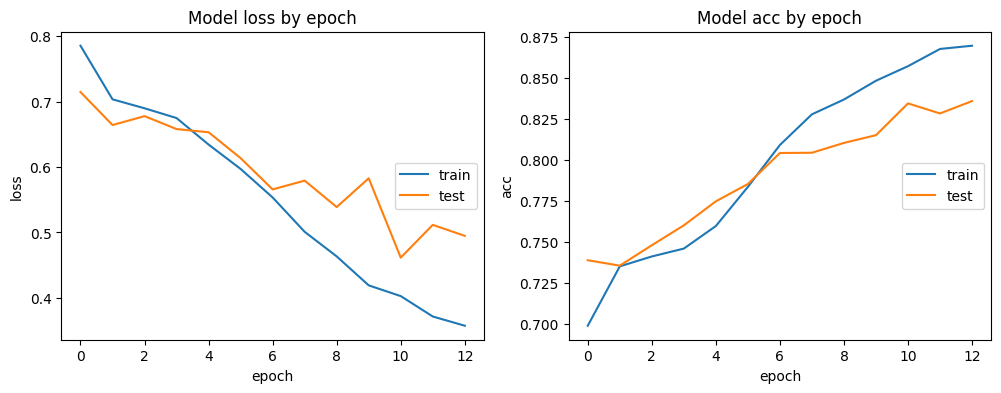

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.92      0.48      0.63      1084
   Lung_Opacity       0.80      0.85      0.82      1803
         Normal       0.86      0.94      0.90      3057
Viral_Pneumonia       0.75      0.95      0.84       403

       accuracy                           0.84      6347
      macro avg       0.83      0.80      0.80      6347
   weighted avg       0.84      0.84      0.83      6347



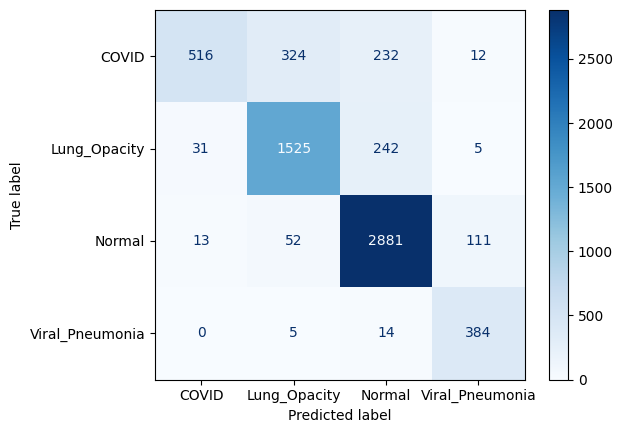

In [16]:
# On redescebnd à un btach de 32 par manque de mémoire

#del base_model
test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

### On degele la moitie des couches et on teste un cosine decay

In [4]:
try:
    model
    del model
except NameError:
    print("Error: model No value detected")

try:
    base_model
    del base_model
except NameError:
    print("Error: base_model No value detected")

try:
    preprocess_input
    del preprocess_input
except NameError:
    print("Error: preprocess_input No value detected")


try:
    history
    del history
except NameError:
    print("Error:history No value detected")


# Libérer de la mémoire
tf.keras.backend.clear_session()
gc.collect()

Error: model No value detected
Error: base_model No value detected
Error: preprocess_input No value detected
Error:history No value detected


23

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import gc
from tensorflow.keras.optimizers.schedules import CosineDecay

#del history
#del model
#del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()


# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)


# first:  freeze all convolutional InceptionV3 layers

for layer in model.layers[:150]:
   layer.trainable = False
for layer in model.layers[150:]:
   layer.trainable = True


#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.001) 

# On crée des callback pour diminuer le LR

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.05)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# On cree un callback pour sauvegarder le meilleur modèle
checkpoint_filepath = '../models/checkpoint/model_resnet50_CHO_v1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode="min", 
    min_delta =  0.00001,
    verbose = 1 )

my_callbacks = [
    scheduler_callback,
    stop_callback,
    model_checkpoint_callback,
]

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])


# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =20,
            verbose=True,
            callbacks=[my_callbacks])


Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20


KeyboardInterrupt: 

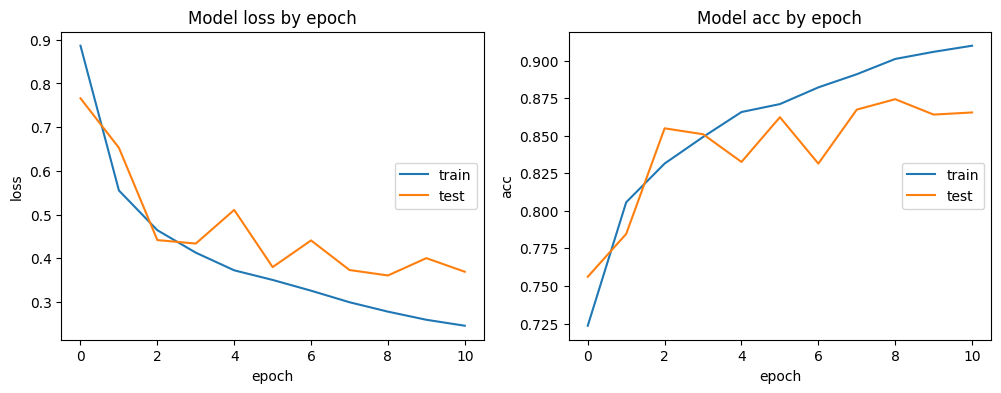

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.75      0.73      0.74      1084
   Lung_Opacity       0.88      0.85      0.86      1803
         Normal       0.90      0.91      0.91      3057
Viral_Pneumonia       0.85      0.95      0.89       403

       accuracy                           0.87      6347
      macro avg       0.84      0.86      0.85      6347
   weighted avg       0.87      0.87      0.87      6347



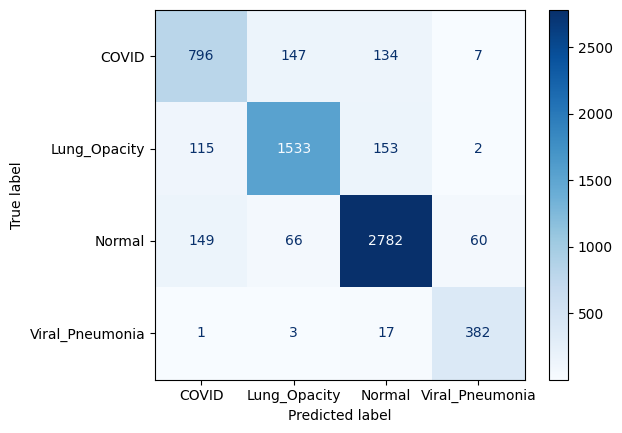

In [29]:

#del base_model
test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

In [6]:
# On charge le modèle

#model = model.load('../models/model_resnet50_CHO_v1')
model = tf.keras.models.load_model("../models/model_resnet50_CHO_v1")

#model.save('../models/model_resnet50_CHO_v1')

#model.summary()

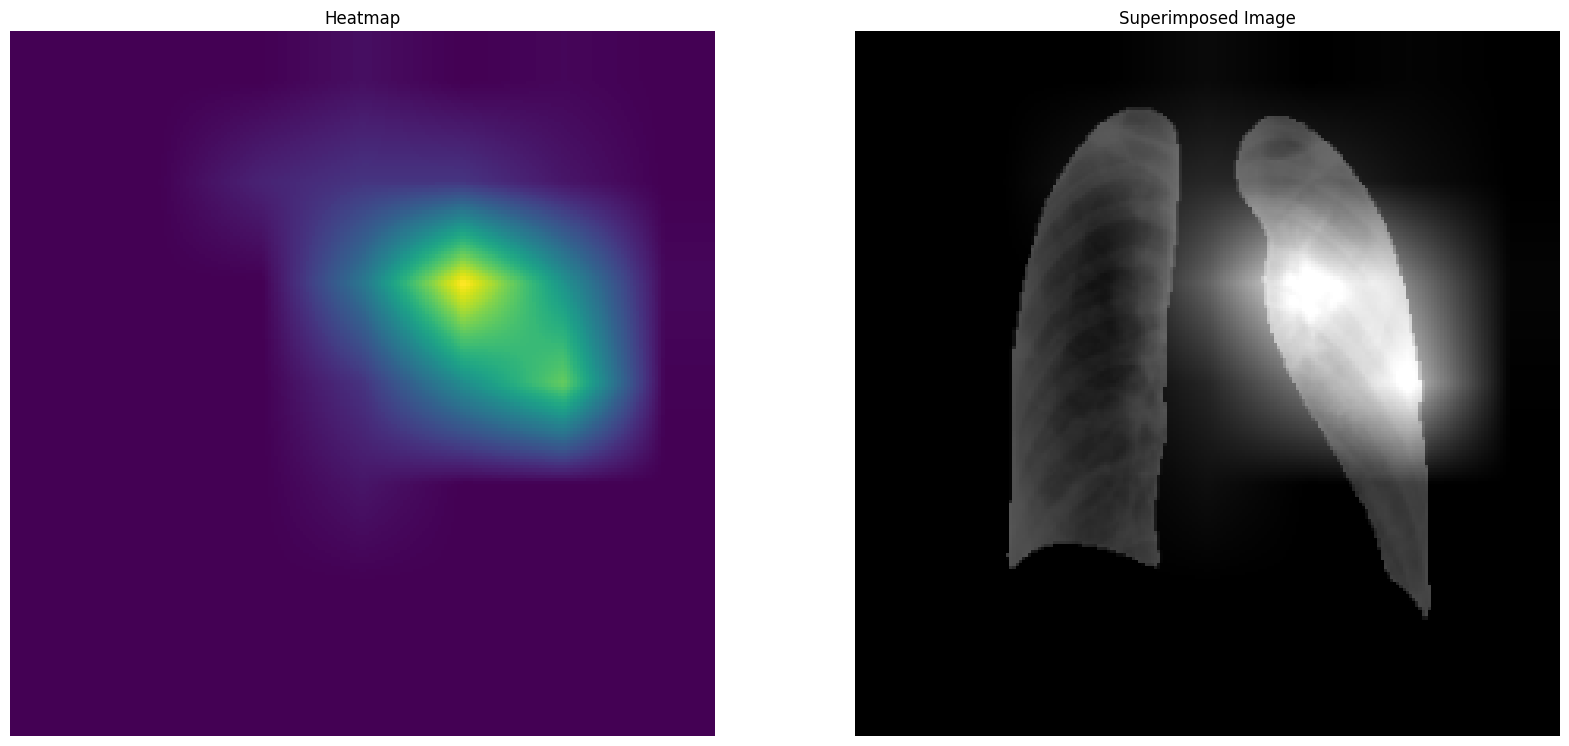

In [7]:
from PIL import Image
import cv2

img_size = (299, 299)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

last_conv_layer_name = "conv5_block3_3_conv"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Modèle pour obtenir les gradients des activations de la dernière couche convolutive
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Obtenir les gradients des activations de la dernière couche convolutive
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplier chaque canal par l'importance de ce canal pour la classe prédite
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normaliser le heatmap entre 0 et 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Charger l'image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    #img = cv2.imread(img_path) 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionner le heatmap pour qu'il corresponde à l'image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.array(Image.fromarray(heatmap).resize((img.shape[1], img.shape[0])))

    # Appliquer le heatmap sur l'image
    heatmap = np.expand_dims(heatmap, axis=-1)
    superimposed_img = alpha * img + heatmap  
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")

    # # Afficher l'image seul
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1) 
    # Afficher le heatmap seul plt.subplot(1, 2, 1) 
    plt.imshow(heatmap[..., 0], cmap='viridis') 
    plt.title('Heatmap') 
    plt.axis('off') 
    
    # Afficher l'image superposée 
    plt.subplot(1, 2, 2) 
    plt.imshow(superimposed_img, cmap='viridis') 
    plt.title('Superimposed Image') 
    plt.axis('off')


# Charger et prétraiter l'image
img_path = os.path.join(data_dir,"COVID","COVID-30.png_masked.png")
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Générer le heatmap Grad-CAM
last_conv_layer_name = "conv5_block3_out"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
# Superposer le heatmap sur l'image
save_and_display_gradcam(img_path,heatmap)


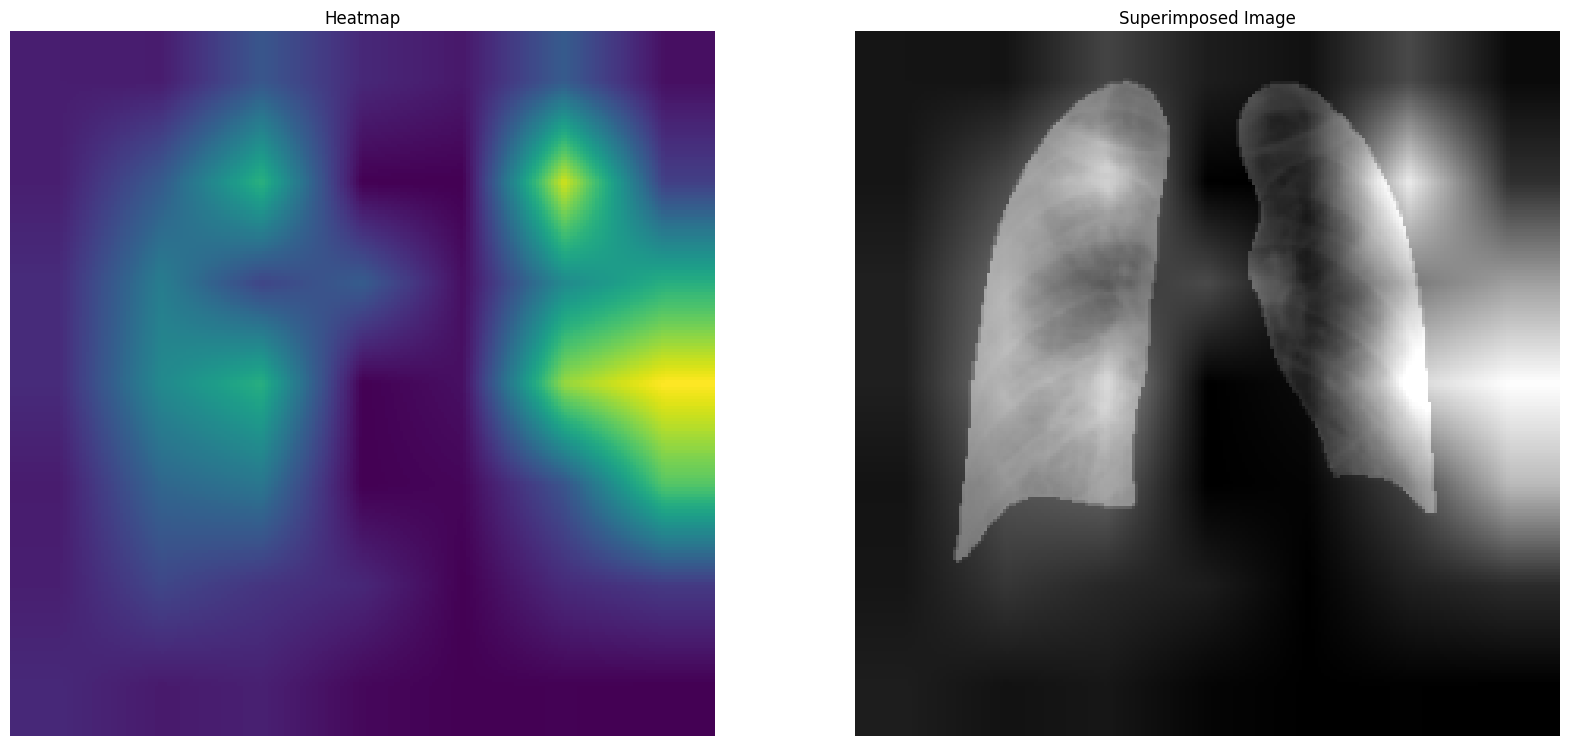

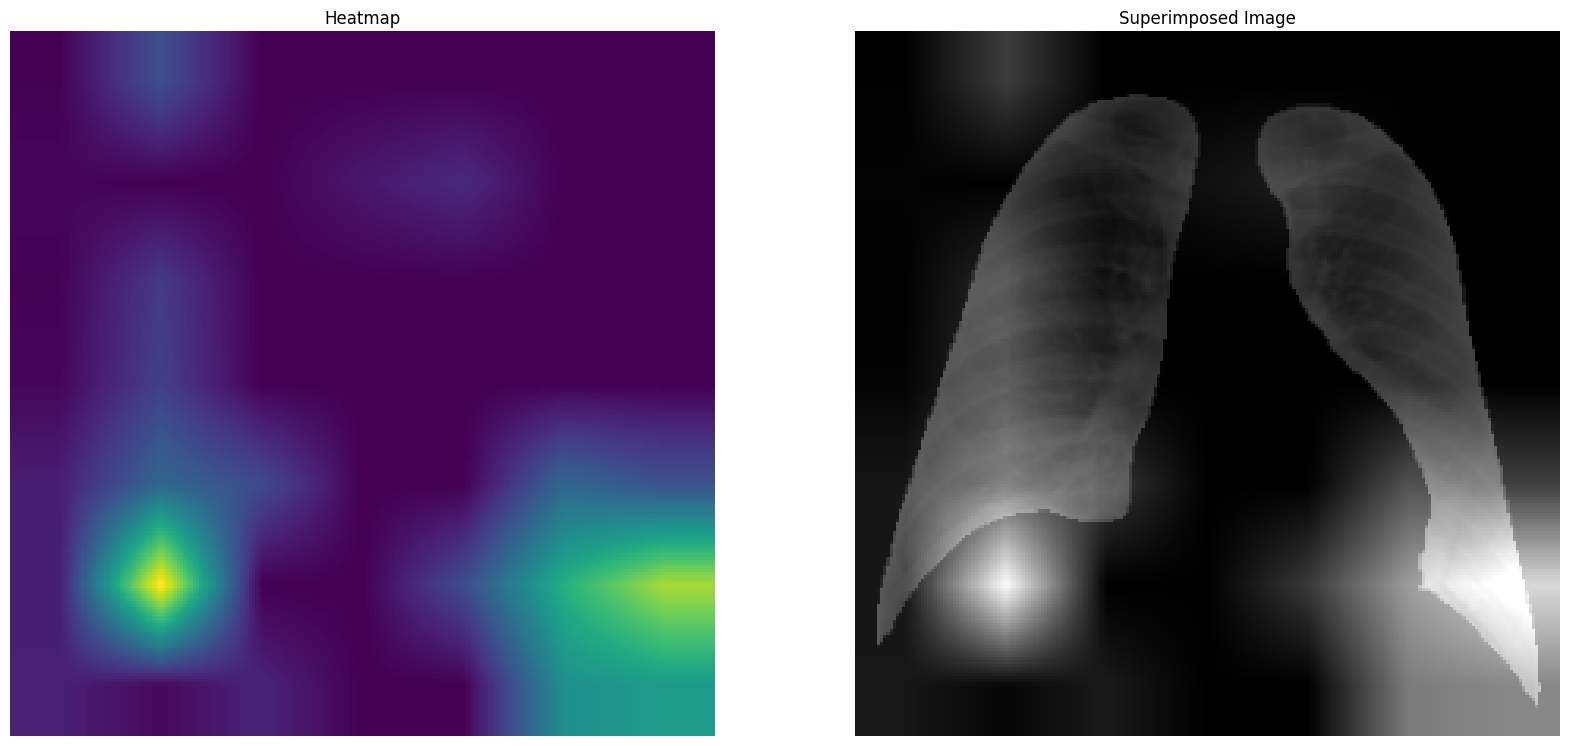

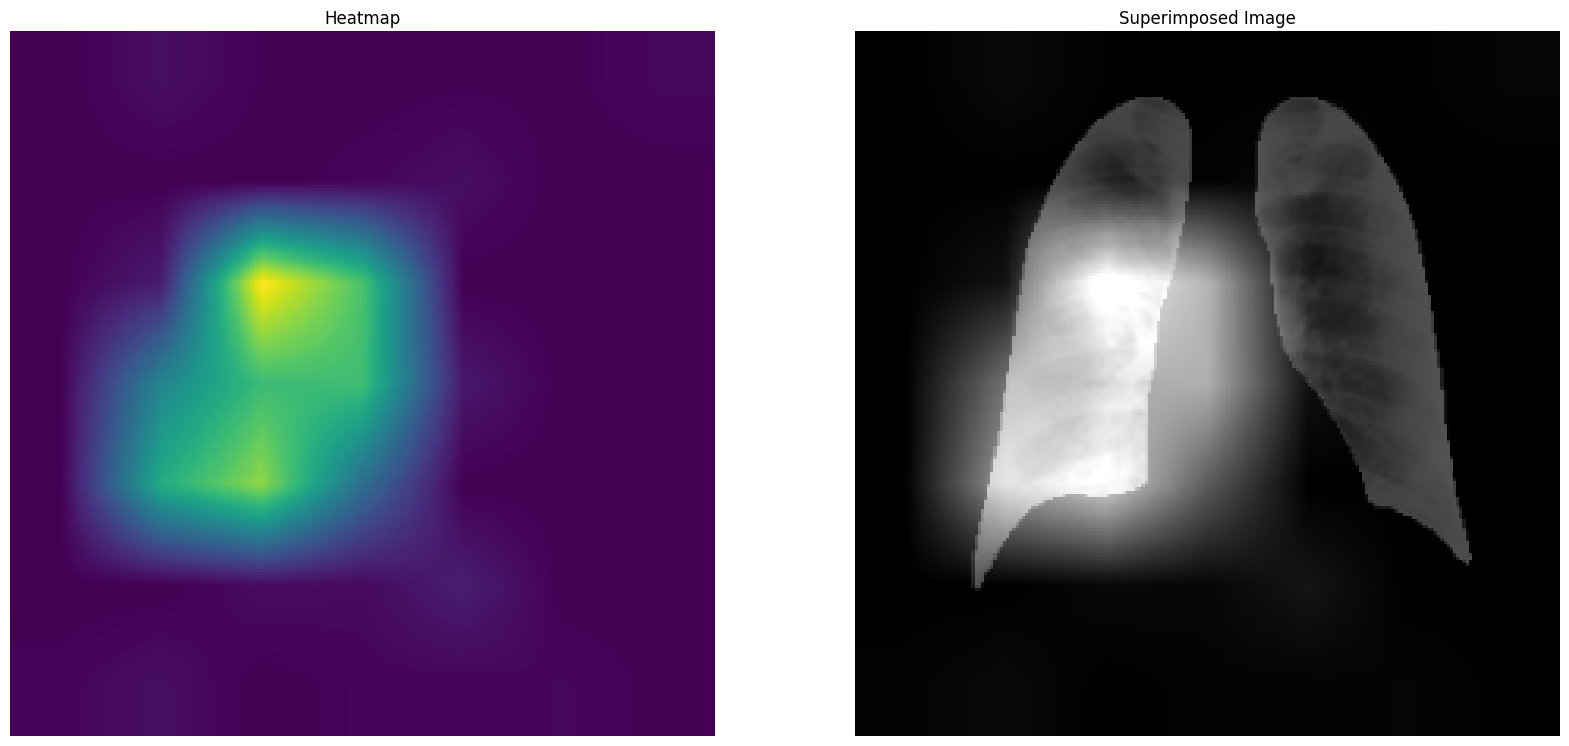

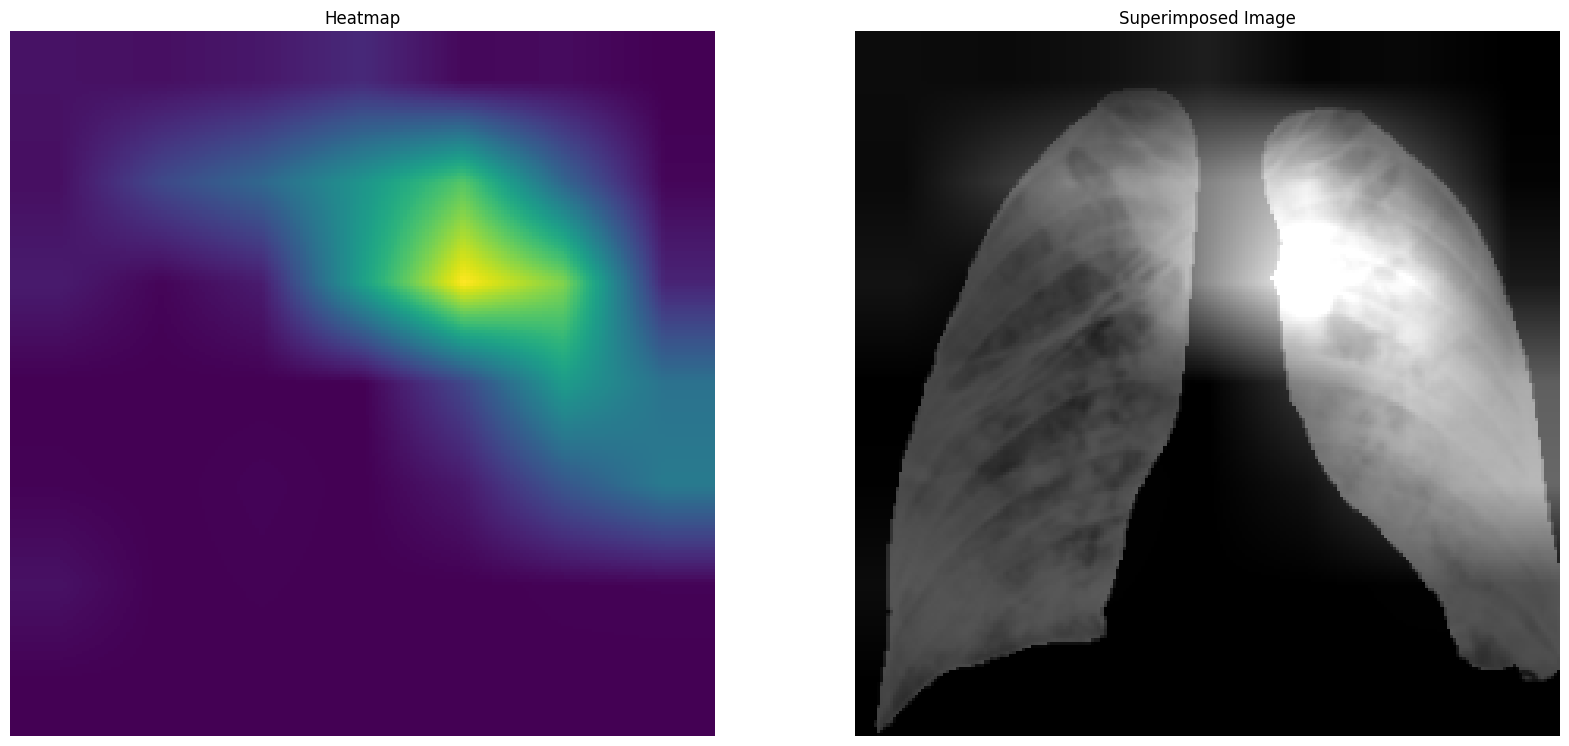

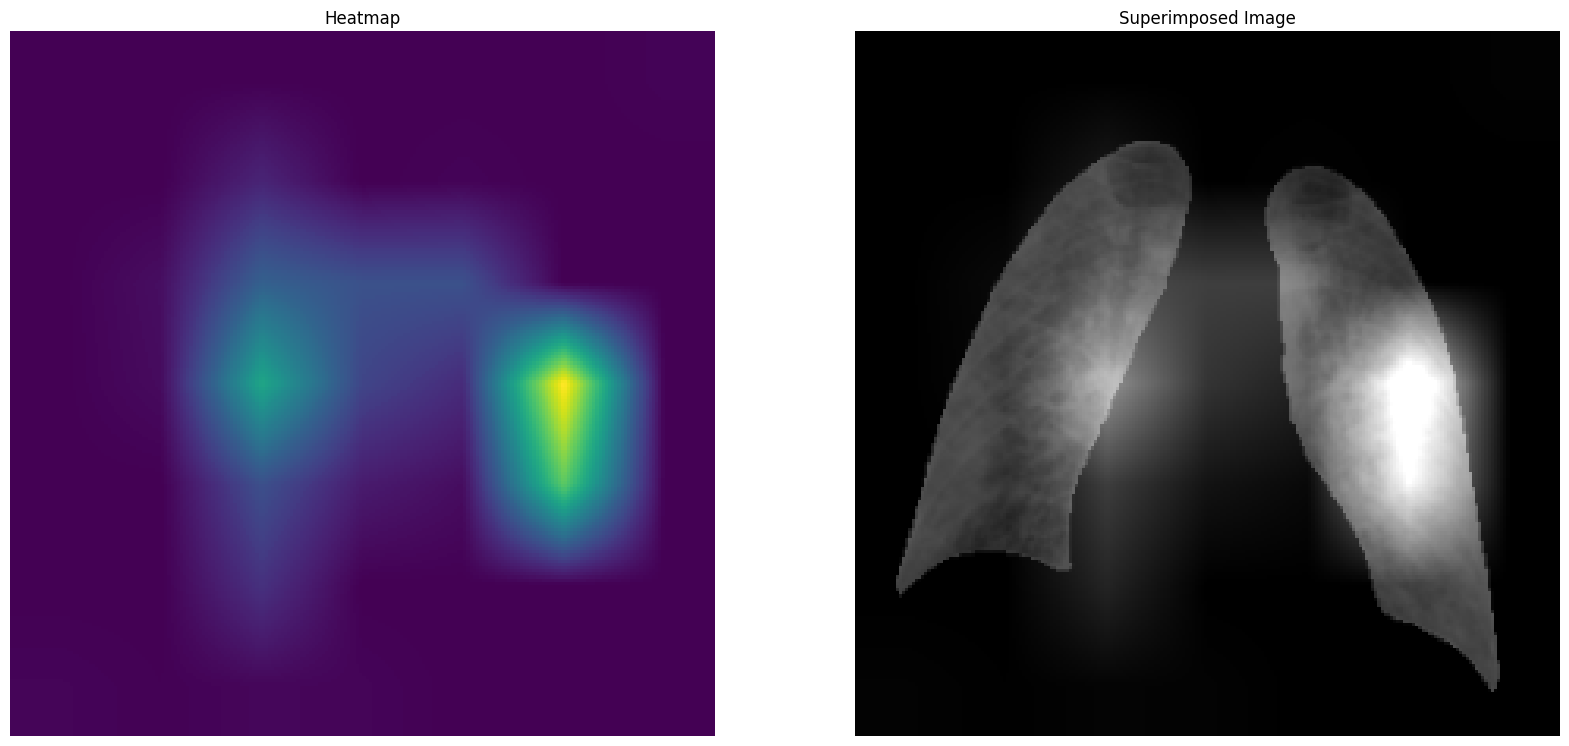

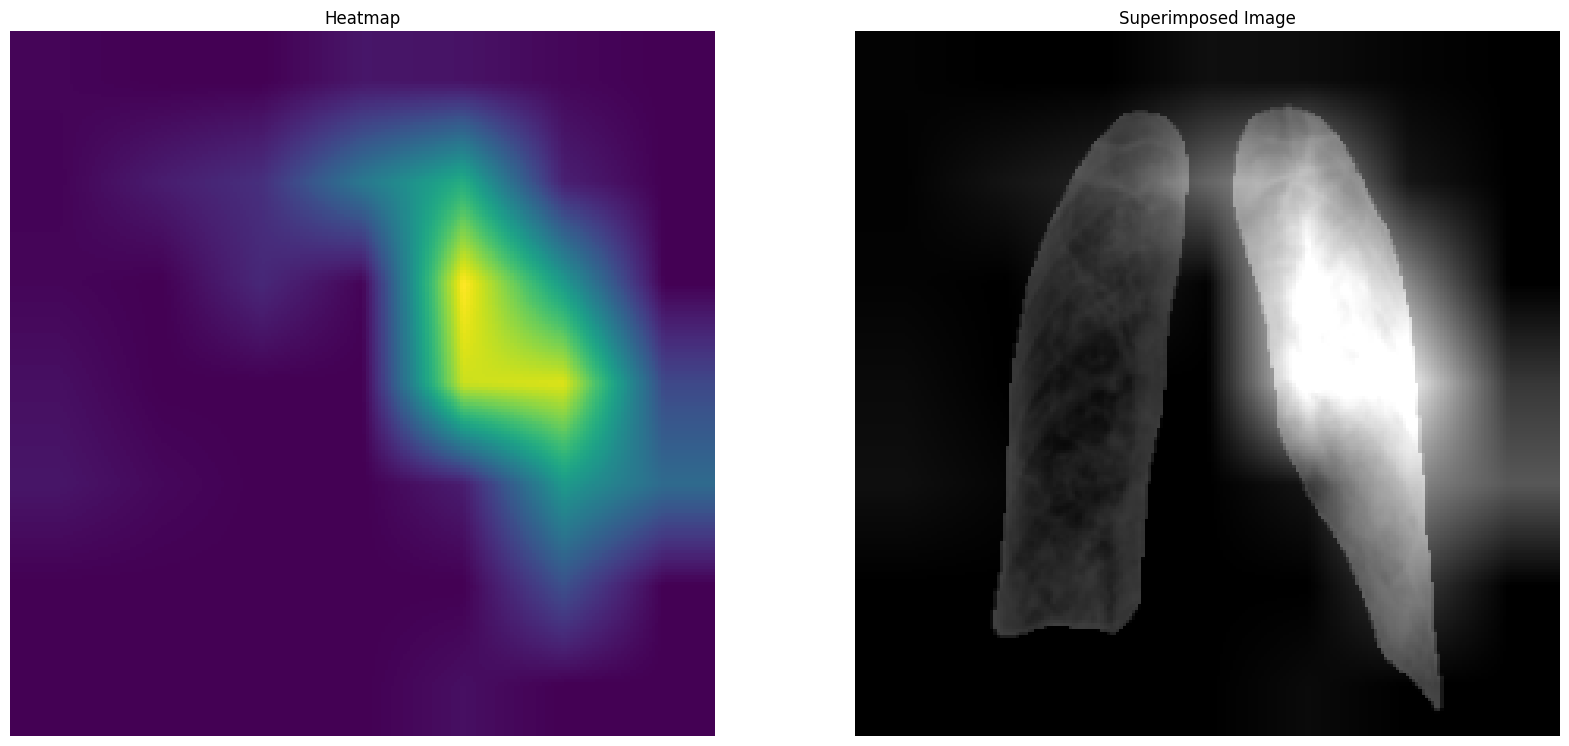

In [115]:
import random

# Obtenir un batch d'images
dataiter = iter(test_dataset)
images, labels = next(dataiter)

x = [random.randint(0, len(images)) for p in range(0, 6)]

# # Parcourir les images du batch
for i in x :
     img_array = np.expand_dims(images[i], axis=0)
     heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")
     img_path = data_dir + '/' + test_dataset.filenames[i]
     save_and_display_gradcam(img_path, heatmap)


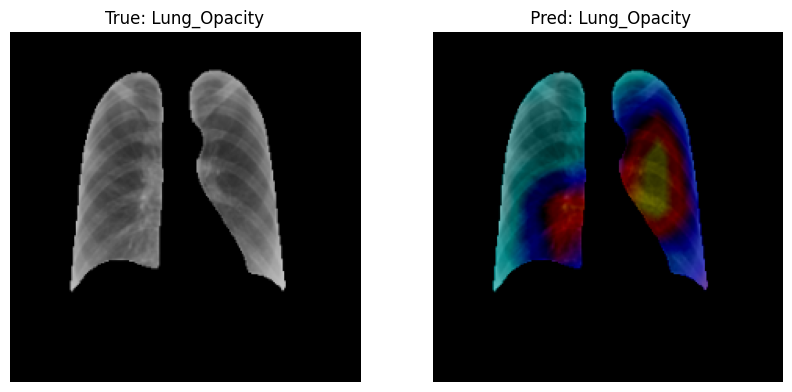

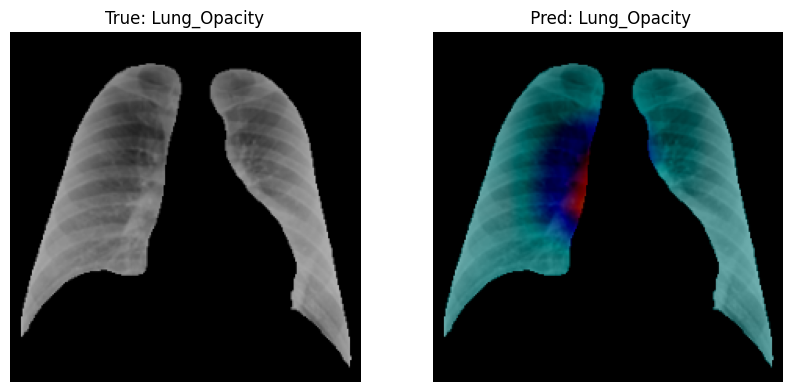

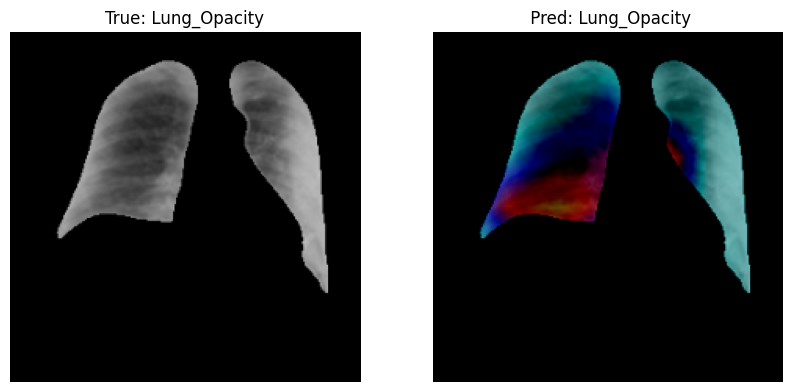

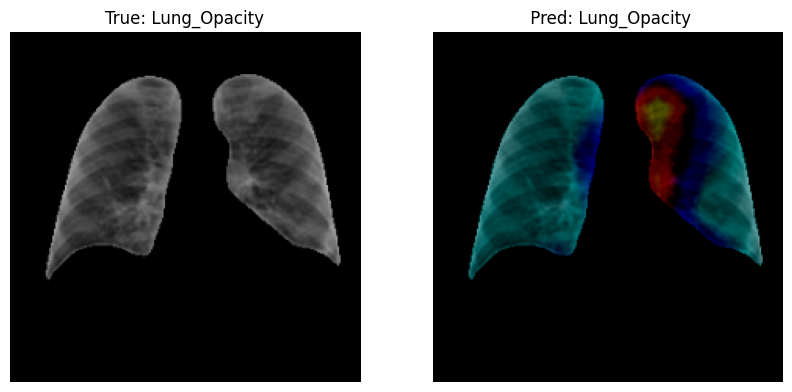

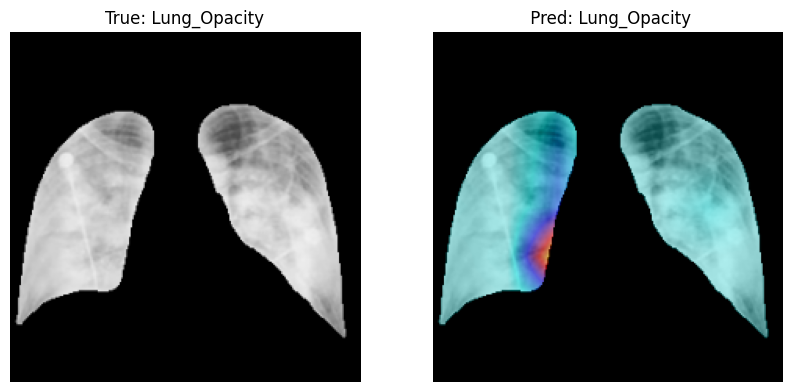

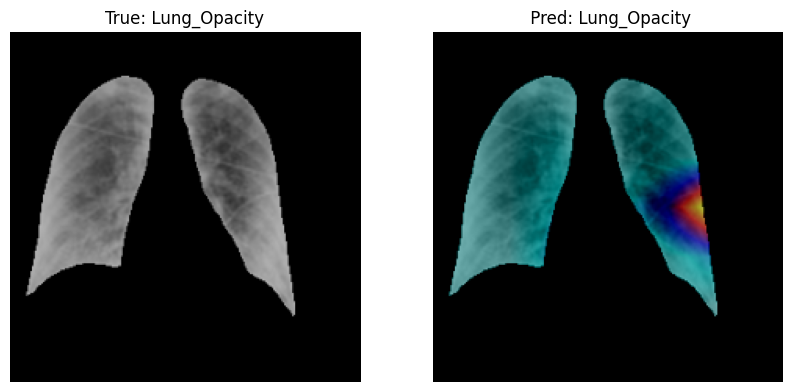

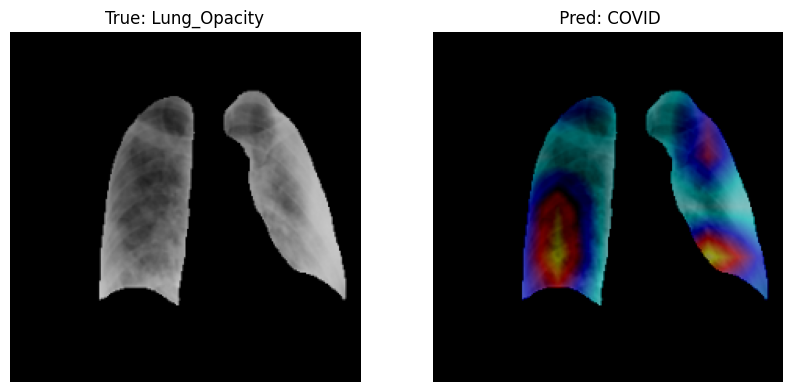

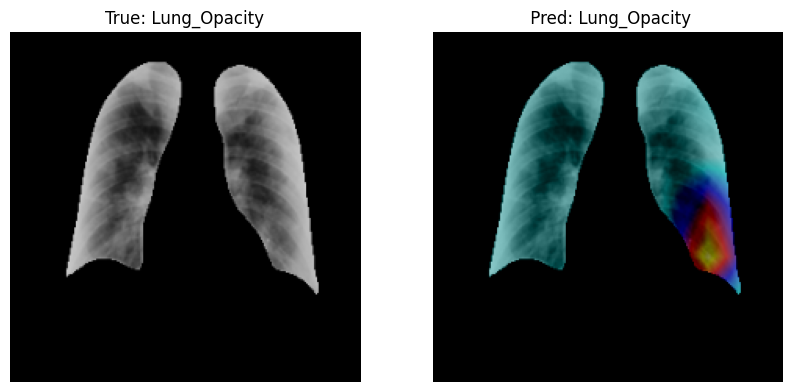

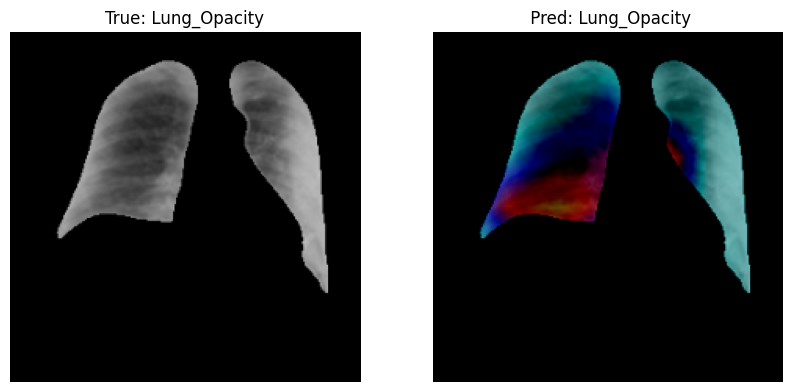

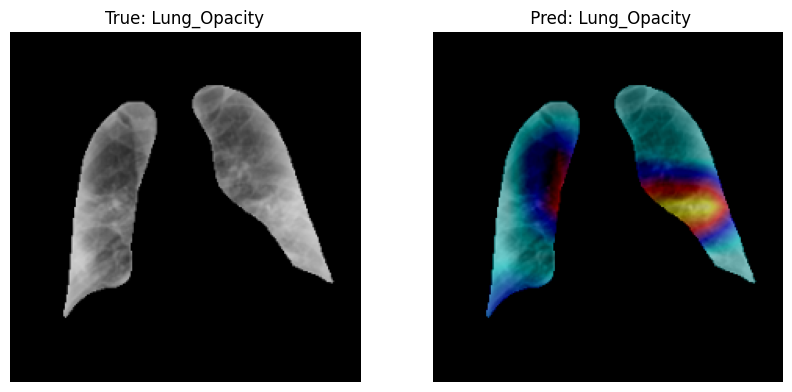

In [26]:
import random

def display_gradcam(img_path, heatmap, pred_label, true_label, alpha=-0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")

    plt.figure(figsize=(20, 10))
 # Afficher l'image superposée 
    plt.subplot(2, 1, 1) 
    plt.imshow(img, cmap='viridis') 
    plt.title(f'True: {true_label}') 
    plt.axis('off')

    plt.subplot(2, 2, 2) 
    plt.title(f' Pred: {pred_label}')
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Obtenir un batch d'images
dataiter = iter(test_dataset)
images, labels = next(dataiter)
class_labels = list(test_dataset.class_indices.keys())


x = [random.randint(0, (len(images)-1)) for p in range(0, 10)]


# Parcourir les images du batch
for i in x:
    img_array = np.expand_dims(images[i], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")
    
    pred_label = class_labels[tf.argmax(model.predict(img_array)[0])]
    true_label = class_labels[tf.argmax(labels[i])]

    img_path = f"{data_dir}/{test_dataset.filenames[i]}"
    display_gradcam(img_path, heatmap, pred_label, true_label)



## Efficientnet B2
### Directement 


In [118]:
# pour refaire de la place sur la gpu
del model
del cm
import gc
gc.collect()
tf.keras.backend.clear_session()


In [ ]:

from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

base_model = EfficientNetB2(weights='imagenet')

#base_model.summary()

len(base_model.layers)

342

In [122]:
#del history
#del model
#del base_model
#del cm
tf.keras.backend.clear_session()
gc.collect()

# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation
batch_size=64
# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        validation_split=validation_ratio,
    ) 


# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42, shuffle=True)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model =  EfficientNetB2(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 


# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.input, outputs=predictions)

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs =10,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/10
231/231 [==============================] - 106s 428ms/step - loss: 1.1384 - accuracy: 0.5410 - val_loss: 1.0057 - val_accuracy: 0.6233
Epoch 2/10
231/231 [==============================] - 93s 403ms/step - loss: 0.9693 - accuracy: 0.6152 - val_loss: 0.9170 - val_accuracy: 0.6403
Epoch 3/10
231/231 [==============================] - 93s 402ms/step - loss: 0.8950 - accuracy: 0.6400 - val_loss: 0.8620 - val_accuracy: 0.6584
Epoch 4/10
231/231 [==============================] - 93s 403ms/step - loss: 0.8518 - accuracy: 0.6541 - val_loss: 0.8283 - val_accuracy: 0.6746
Epoch 5/10
231/231 [==============================] - 93s 400ms/step - loss: 0.8198 - accuracy: 0.6751 - val_loss: 0.7993 - val_accuracy: 0.6857
Epoch 6/10
231/231 [==============================] - 93s 400ms/step - loss: 0.7980 - accuracy: 0.6812 - val_loss: 0.7793 - val_accuracy: 0.6902
Epoch 7/10
231/231 [========================

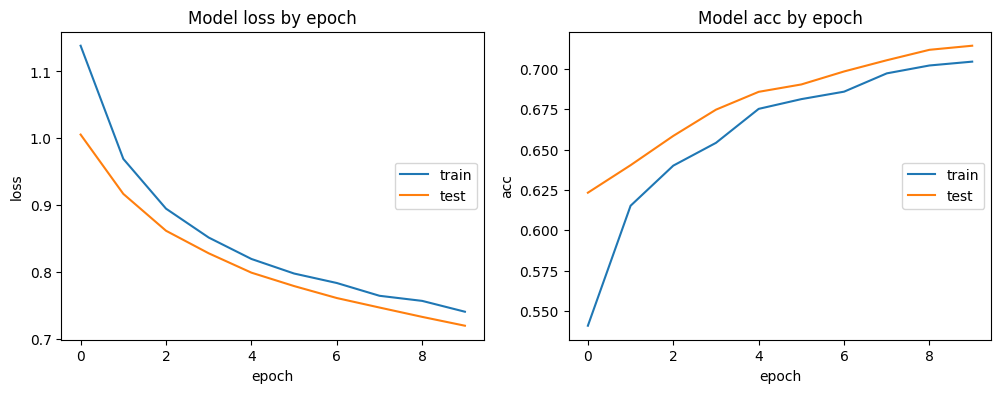

In [123]:
# On trace l evolution de la loss

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.61      0.19      0.29      1084
   Lung_Opacity       0.65      0.74      0.69      1803
         Normal       0.77      0.91      0.83      3057
Viral_Pneumonia       0.67      0.59      0.63       403

       accuracy                           0.72      6347
      macro avg       0.67      0.61      0.61      6347
   weighted avg       0.70      0.72      0.69      6347



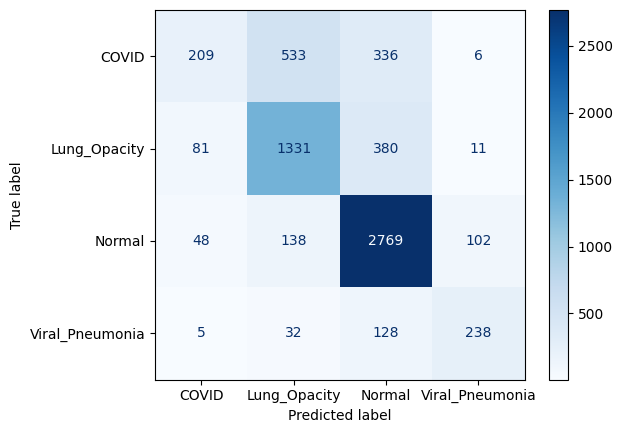

In [124]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

### Degel des dernieres couches

In [ ]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers:
   layer.trainable = False

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.1) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 20,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/20
231/231 [==============================] - 211s 877ms/step - loss: 1.2010 - accuracy: 0.6853 - val_loss: 1.0561 - val_accuracy: 0.7304
Epoch 2/20
231/231 [==============================] - 198s 858ms/step - loss: 0.9807 - accuracy: 0.7129 - val_loss: 0.9128 - val_accuracy: 0.7618
Epoch 3/20
231/231 [==============================] - 198s 858ms/step - loss: 0.8525 - accuracy: 0.7700 - val_loss: 0.7664 - val_accuracy: 0.8089
Epoch 4/20
231/231 [==============================] - 221s 957ms/step - loss: 0.7775 - accuracy: 0.7773 - val_loss: 0.6943 - val_accuracy: 0.8144
Epoch 5/20
231/231 [==============================] - 189s 818ms/step - loss: 0.7249 - accuracy: 0.7864 - val_loss: 0.6646 - val_accuracy: 0.8128
Epoch 6/20
231/231 [==============================] - 187s 810ms/step - loss: 0.6688 - accuracy: 0.7982 - val_loss: 0.6052 - val_accuracy: 0.8193
Epoch 7/20
231/231 [===================

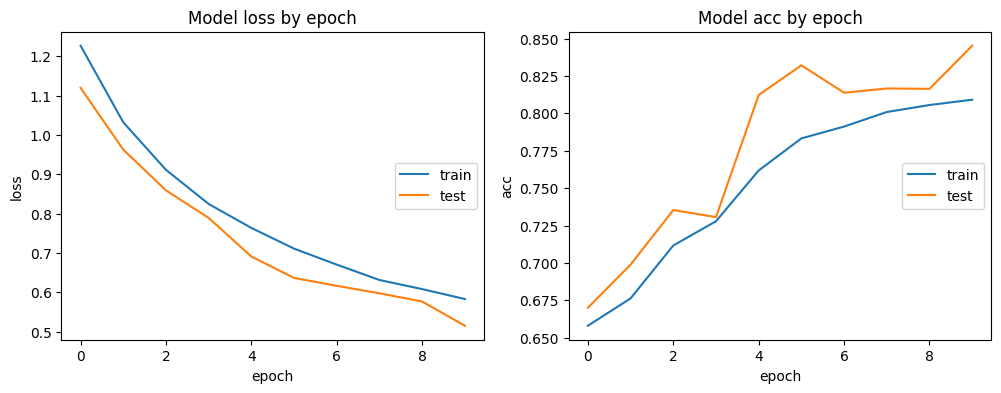

In [77]:
# On trace l evolution de la loss

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 8464 images belonging to 4 classes.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      1446
           1       0.83      0.83      0.83      2404
           2       0.87      0.93      0.90      4076
           3       0.88      0.89      0.89       538

    accuracy                           0.85      8464
   macro avg       0.84      0.82      0.82      8464
weighted avg       0.84      0.85      0.84      8464



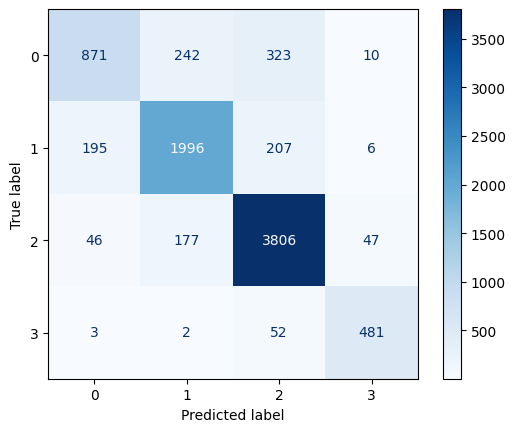

In [78]:
# On fait la matrice de confusion et le rapport de classification

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

In [5]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

# x = base_model.output
# x = Flatten()(x)
# #x = Dense(60, activation='relu')(x) 
# predictions = Dense(4, activation='softmax')(x) 

# model = Model(inputs=base_model.input, outputs=predictions)


# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure
base_model = tf.keras.applications.resnet_v2.ResNet101V2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')


N=round(len(base_model.layers)*0)

print(N)

print("Le modèle contient :", len(base_model.layers), "couches, on en gele ", N )


model = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])


# on degele les dix dernieres couches:
for layer in model.layers:
   layer.trainable = True

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=0.1) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 20,
            verbose=True)



NameError: name 'preprocess_input' is not defined

## Efficient B0

In [21]:

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

base_model = EfficientNetB0(weights='imagenet')

#base_model.summary()


len(base_model.layers)

21848064/21834768 [==============================] - 2s 0us/step


240

In [22]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation

batch_size=64

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers:
   layer.trainable = False

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# # train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.
Epoch 1/10
231/231 [==============================] - 166s 692ms/step - loss: 1.3880 - accuracy: 0.2042 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 2/10
231/231 [==============================] - 166s 718ms/step - loss: 1.3881 - accuracy: 0.2044 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 3/10
231/231 [==============================] - 173s 750ms/step - loss: 1.3882 - accuracy: 0.2029 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 4/10
231/231 [==============================] - 168s 728ms/step - loss: 1.3881 - accuracy: 0.2060 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 5/10
231/231 [==============================] - 167s 720ms/step - loss: 1.3882 - accuracy: 0.2020 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 6/10
231/231 [==============================] - 161s 694ms/step - loss: 1.3881 - accuracy: 0.2033 - val_loss: 1.3887 - val_accuracy: 0.1344
Epoch 7/10
231/231 [===================

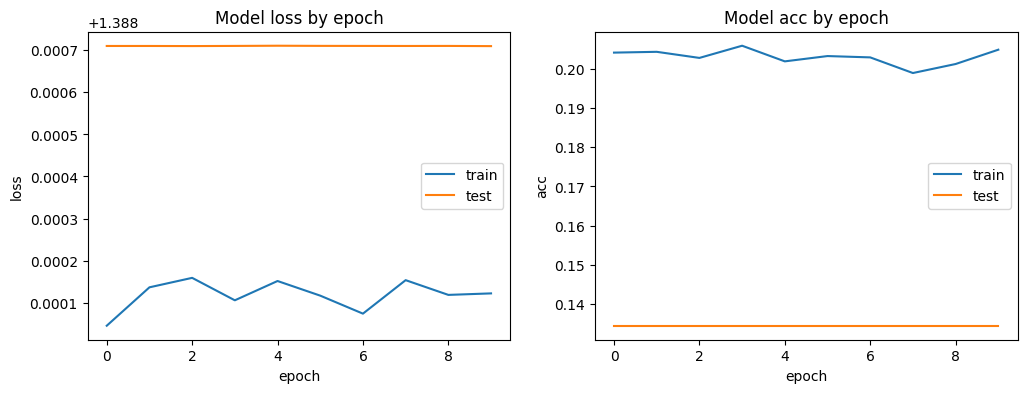

In [23]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 6347 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.13      0.14      0.13      1084
   Lung_Opacity       0.13      0.01      0.02      1803
         Normal       0.28      0.21      0.24      3057
Viral_Pneumonia       0.02      0.15      0.04       403

       accuracy                           0.13      6347
      macro avg       0.14      0.12      0.11      6347
   weighted avg       0.20      0.13      0.14      6347



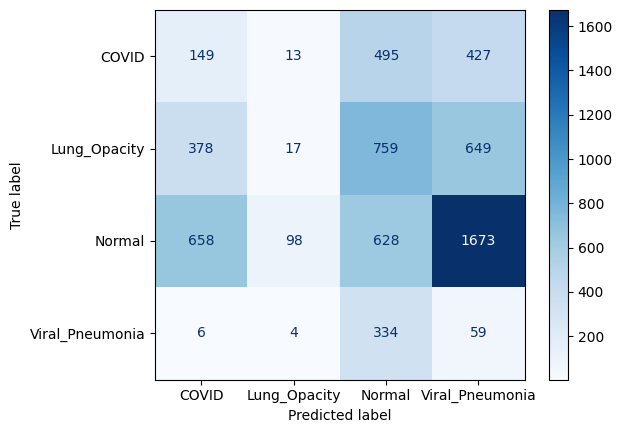

In [24]:
test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

In [ ]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers[:300]:
   layer.trainable = False

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# # train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

Found 12701 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 155s 767ms/step - loss: 1.2273 - accuracy: 0.6439 - val_loss: 1.0906 - val_accuracy: 0.6928
Epoch 2/10
198/198 [==============================] - 168s 846ms/step - loss: 1.0087 - accuracy: 0.7131 - val_loss: 0.9356 - val_accuracy: 0.7150
Epoch 3/10
198/198 [==============================] - 168s 846ms/step - loss: 0.8743 - accuracy: 0.7431 - val_loss: 0.8188 - val_accuracy: 0.7780
Epoch 4/10
198/198 [==============================] - 177s 891ms/step - loss: 0.7957 - accuracy: 0.7757 - val_loss: 0.7525 - val_accuracy: 0.7850
Epoch 5/10
198/198 [==============================] - 176s 887ms/step - loss: 0.7419 - accuracy: 0.7806 - val_loss: 0.6944 - val_accuracy: 0.7968
Epoch 6/10
198/198 [==============================] - 176s 887ms/step - loss: 0.7044 - accuracy: 0.7841 - val_loss: 0.6716 - val_accuracy: 0.7995
Epoch 7/10
198/198 [===================

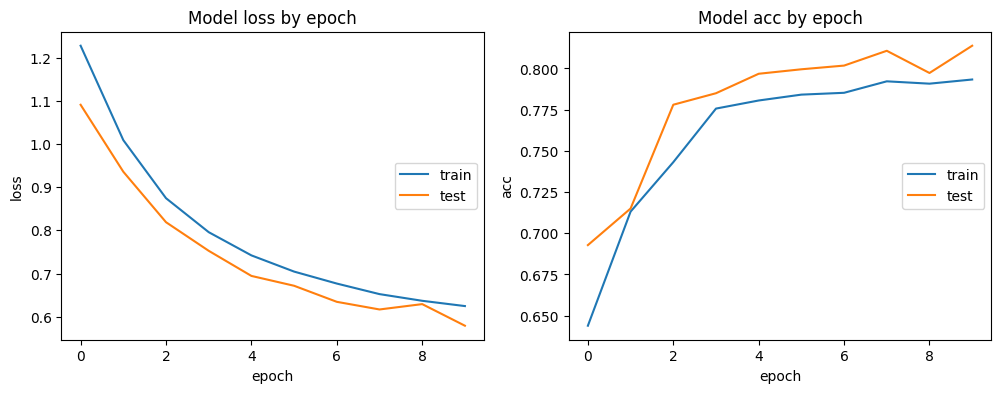

In [92]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 8464 images belonging to 4 classes.
Confusion Matrix
Classification Report
                 precision    recall  f1-score   support

          COVID       0.67      0.59      0.63      1446
   Lung_Opacity       0.85      0.73      0.79      2404
         Normal       0.84      0.94      0.88      4076
Viral_Pneumonia       0.83      0.85      0.84       538

       accuracy                           0.81      8464
      macro avg       0.80      0.78      0.78      8464
   weighted avg       0.81      0.81      0.81      8464



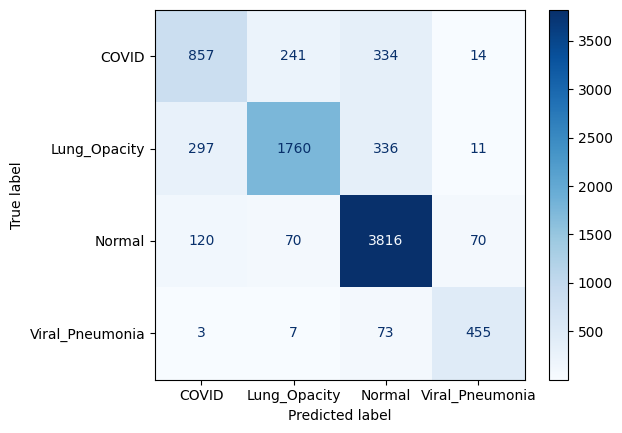

In [100]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)
labels = list(test_dataset.class_indices.keys())

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= labels)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=labels))

In [ ]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.7 # Pourcentage de données d'entraînement 
validation_ratio = 0.3 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele l ensemble des couches:
for layer in model.layers :
   layer.trainable = True

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# # train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']